In [1]:
import os
import shutil
import nibabel as nib
import numpy as np
from scipy import ndimage

In [2]:
# Define a recursive function to traverse the folder
def get_nii_files(folder):
    nii_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.nii'):
                nii_files.append(os.path.join(root, file))
    return nii_files

In [3]:
# Get the NII path list in all folders
nii_files = []
folders = ['E:/MCI/ADNI']
for folder in folders:
    nii_files += get_nii_files(folder)

# Specify the destination folder path to move t
target_folder = 'E:/MCI'

# Move files
for nii_file in nii_files:
    shutil.move(nii_file, target_folder)

In [10]:
import pandas as pd
import csv

file1 = 'C:/2023春/毕业论文/466.csv'
file2 = 'C:/2023春/毕业论文/对比.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# compare two dataframe
#diff = df1.compare(df2)
#print(diff)

merged_df = pd.concat([df1,df2]).drop_duplicates(keep=False)
#print(merged_df)


In [8]:
file3 = 'C:/2023春/毕业论文/全新.csv'
df3 = pd.read_csv(file3)

merged_df1 = pd.concat([df3,merged_df],ignore_index=True)
merged_df1.drop_duplicates(keep=False,inplace=True)
merged_df.to_csv('new_file.csv',index=False)

### Image quality control

In [2]:
import nibabel as nib
import numpy as np
from scipy import ndimage

# load nii image
img = nib.load('E:/image_corrected_brain1.nii.gz')
#img=nib.load('new_example1.nii')
data = img.get_fdata()

# Check the shape
size = img.shape
if size != (256, 256, 192):
    print('图像尺寸错误')


affine = img.affine
#if np.abs(np.linalg.det(affine[:3, :3]) - 1) > 1e-3:
#    print('图像方向错误')

# Check spatial coordinate information
if not np.allclose(affine[:3, 3], [-128, -128, -88]):
    print('图像空间位置错误')

# Check image quality
mean_intensity = np.mean(data)
std_intensity = np.std(data)
if mean_intensity < 0.1 or mean_intensity > 100 or std_intensity < 0.01 or std_intensity > 50:
    print('图像质量异常')

# check motion artifacts
#motion_params = np.loadtxt('motion_params.txt')
#if np.any(np.abs(np.diff(motion_params, axis=0)) > 0.5):
    #print('存在运动伪影')

图像尺寸错误
图像空间位置错误
图像质量异常


In [4]:
#image correction
def correct_nii(nii_path):
    img = nib.load(nii_path)
    affine = img.affine
    data = img.get_fdata()
    
    #尺寸矫正
    new_shape = (256, 256, 192)
    data = np.rot90(data.squeeze(),1)
    scale = np.array(new_shape) / np.array(data.shape)
    img_resized = ndimage.zoom(data, scale, order=1)
    nii_resized = nib.Nifti1Image(img_resized, affine)
    data_1 = nii_resized.get_fdata()
    
    #伪影矫正
    data_2 = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(data_1))))
    nii_artifact = nib.Nifti1Image(data_2, nii_resized.affine)
    data_3 = nii_artifact.get_fdata()
    
    #信号强度矫正
    img_mean = data_3.mean()
    img_corrected = data_3 - img_mean
    header = nii_artifact.header
    nii_corrected = nib.Nifti1Image(img_corrected, affine=header.get_best_affine())
    data_4 = nii_corrected.get_fdata()
    
    #空间位置矫正
    affine = nii_corrected.affine
    origin_offset = np.array([data_4.shape[i] * affine[i, i] / 2 for i in range(3)])
    new_origin = np.zeros(3)
    affine[:3, 3] = new_origin - origin_offset# 将原点移动到(0,0,0)

    img.set_qform(affine, code=1)# 更新affine矩阵
    
    ###图像纠偏
    data = img.get_fdata()
    affine = img.affine
    if np.linalg.det(affine[:3,:3]) < 0:
    # 反转第一个维度
        data = data[::-1,:,:]
        affine[:3,:3] = affine[:3,:3] * np.array([[-1,0,0],[0,1,0],[0,0,1]])
    nii_corrected = nib.Nifti1Image(data, affine)

    # 保存新的nii文件
    #output_filename = os.path.join(nii_corrected,file_name)
    output_filename = os.path.join(output_folder,file_name)
    nib.save(img, output_filename)

In [5]:
output_folder = 'E:/毕业论文/MCI补充矫正纠偏'

In [90]:
correct_nii('C:/2023春/毕业论文/sMRI图像/ADNI_023_S_0042_MR_MPRAGE_br_raw_20120105144614299_60_S135489_I275399.nii')

In [6]:
nii_dir = 'E:/毕业论文/MCI补充'
for file_name in os.listdir(nii_dir):
    file_path = os.path.join(nii_dir, file_name)
    correct_nii(file_path)

C:\Users\86180\anaconda3\lib\site-packages\nibabel\dataobj_images.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.asanyarray(self._dataobj, dtype=dtype)


In [35]:
#矫正尺寸
# 获取原始图像数据和头文件
#img = nii.get_fdata()
affine = img.affine
# 设置新的图像尺寸
new_shape = (256, 256, 192)
# 计算原始图像和新图像之间的尺寸比例
scale = np.array(new_shape) / np.array(data.shape)
# 修改图像尺寸
img_resized = ndimage.zoom(data, scale, order=1)
# 创建新的nii对象并保存
nii_resized = nib.Nifti1Image(img_resized, affine)
nib.save(nii_resized, 'example_resized.nii')

In [50]:
#伪影矫正
data = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(data))))
# 保存修正后的图像
nib.save(nib.Nifti1Image(data, img.affine), 'corrected_image.nii')

In [60]:
#信号强度矫正
img_mean = data.mean()
img_corrected = data - img_mean
nii_corrected = nib.Nifti1Image(img_corrected, affine=header.get_best_affine())
nib.save(nii_corrected, 'output.nii')

In [65]:
#空间位置矫正
# 计算原点偏移量
origin_offset = np.array([data.shape[i] * affine[i, i] / 2 for i in range(3)])
# 将原点移动到(0,0,0)
new_origin = np.zeros(3)
affine[:3, 3] = new_origin - origin_offset
# 更新affine矩阵
img.set_qform(affine, code=1)
# 保存新的nii文件
nib.save(img, 'new_example1.nii')

In [68]:
img1 = nib.load('E:/毕业论文/sMRI图像/ADNI_002_S_0729_MR_MPRAGE_br_raw_20120807131656235_129_S159861_I322046.nii')
data1 = img1.get_fdata()

In [69]:
img1.shape

(170, 256, 256, 1)

In [6]:
img2.shape

(91, 109, 91)

In [6]:
img3 = nib.load('009.nii')
data3 = img3.get_fdata()

In [70]:
print(img1.affine)

[[  1.19999695   0.           0.         126.03368378]
 [  0.           1.           0.         151.25578308]
 [  0.           0.           1.         379.32104492]
 [  0.           0.           0.           1.        ]]


In [11]:
import nibabel as nib
from nilearn.image import resample_img
import numpy as np

# Load the MRI image
img = nib.load('E:/毕业论文/sMRI配准/ADNI_009_S_2381_MR_MPRAGE_br_raw_20120531181829640_160_S152280_I307370.nii_brain.nii_registered.nii.gz')

# Define the target affine matrix
LPI_affine = np.array([[-1, 0, 0, img.shape[0]-1],
                       [0, -1, 0, img.shape[1]-1],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])
target_affine = nib.affines.from_matvec(LPI_affine[:3, :3], LPI_affine[:3, 3])

# Resample the image to the target affine matrix
new_img = resample_img(img, target_affine, interpolation='continuous')

# Save the corrected image to a new file
nib.save(new_img, '009.nii')

In [5]:
print(img2.affine)

[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


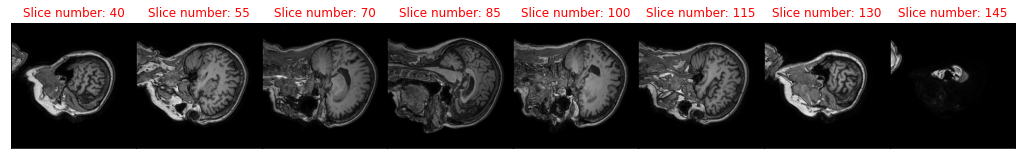

In [81]:
#data1 = np.rot90(data1.squeeze(),1)
#切片
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 8, figsize=[18, 4])
n = 0
slice = 40
for _ in range(8):
    ax[n].imshow(data1[slice,:,:], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 15
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [114]:
img2.shape

(176, 240, 256)

In [54]:
img2 = nib.load('E:/毕业论文/CNMCIAD/ADNI_024_S_4084_MR_MPRAGE_br_raw_20120719155738498_95_S158106_I316993.nii_brain.nii_registered.nii.gz')
data2 = img2.get_fdata()

In [55]:
data2 = np.rot90(data2.squeeze(),1)

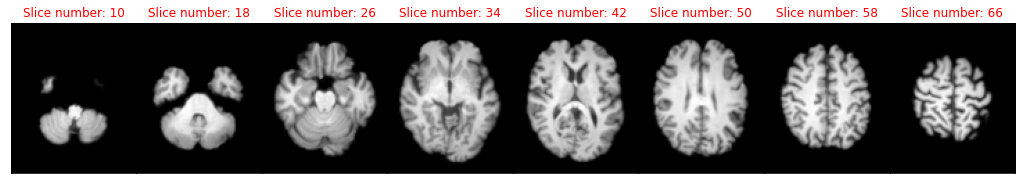

In [56]:
#切片
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 8, figsize=[18, 4])
n = 0
slice = 10
for _ in range(8):
    ax[n].imshow(data2[:,:,slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 8
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [86]:
img2_ = nib.load('E:/毕业论文/sMRI配准1/ADNI_002_S_4447_MR_MPRAGE_br_raw_20120117220923514_62_S137139_I278815.nii_brain.nii_registered.nii.gz')
data2_ = img2_.get_fdata()

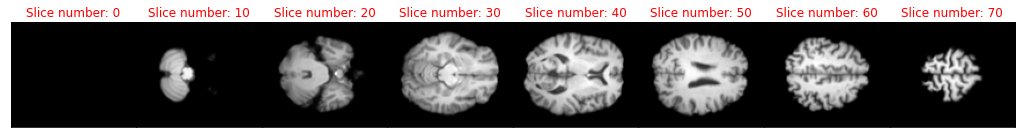

In [88]:
#data2_ = np.rot90(data2_.squeeze(),1)
#切片
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 8, figsize=[18, 4])
n = 0
slice = 0
for _ in range(8):
    ax[n].imshow(data2_[:, :,slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

## 图像纠偏

In [4]:
import numpy as np
import nibabel as nib

# 加载nii文件
nii = nib.load('E:/毕业论文/sMRI矫正/image.nii')

# 获取原始数据和空间信息
data = nii.get_fdata()
affine = nii.affine

# 计算图像方向矩阵的行列式，判断是否需要纠正
if np.linalg.det(affine[:3,:3]) < 0:
    # 反转第一个维度
    data = data[::-1,:,:]
    affine[:3,:3] = affine[:3,:3] * np.array([[-1,0,0],[0,1,0],[0,0,1]])

# 创建纠正后的nii对象
nii_corrected = nib.Nifti1Image(data, affine)

# 保存纠正后的nii文件
nib.save(nii_corrected, 'image_corrected.nii')

## 去头骨

In [60]:
nii = nib.load('image_corrected.nii')
nii_data = nii.get_fdata()
header = nii.header
affine = nii.affine

#threshold = np.max(nii_data) / 2
#mask = np.where(nii_data > threshold, 0, 1)
#mask = np.array(mask, dtype=np.uint8)

# 创建新的nii文件并保存
#new_nii = nib.Nifti1Image(nii_data * mask, affine)

data = nii_data.astype(np.float32)
thresh =90

#data[data<thresh]=0
data[data<thresh]=0

new_img = nib.Nifti1Image(data, affine)

In [61]:
data = new_img.get_fdata()

In [65]:
np.max(nii_data)

1025.0

In [2]:
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe

# 创建一个去除头骨的节点
bet = pe.Node(interface=fsl.BET(), name='bet')
bet.inputs.in_file = 'image_corrected.nii'
bet.inputs.out_file = 'image_corrected1.nii'

# 运行节点
bet.run()
bet image_corrected.nii brain_skullstripped.nii -S -m

In [2]:
import subprocess

# 输入和输出文件路径
input_file = '/mnt/e/image_corrected'
output_file = '/mnt/e/image_corrected'

# 调用FSL的bet命令，去除头骨
cmd = f'/usr/local/fsl/bin/bet {input_file} {output_file} -f 0.5 -g 0'
print(f'Running command: {cmd}')
subprocess.run(cmd, shell=True)

Running command: /usr/local/fsl/bin/bet /mnt/e/image_corrected /mnt/e/image_corrected -f 0.5 -g 0


CompletedProcess(args='/usr/local/fsl/bin/bet /mnt/e/image_corrected /mnt/e/image_corrected -f 0.5 -g 0', returncode=1)

In [38]:
print(subprocess.run)

<function run at 0x000002059B89E790>
